In [0]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

  0%|          | 16384/9912422 [00:00<01:13, 135119.23it/s]

9920512it [00:00, 30651874.06it/s]                           


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 444900.00it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6987448.12it/s]                           
8192it [00:00, 176331.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

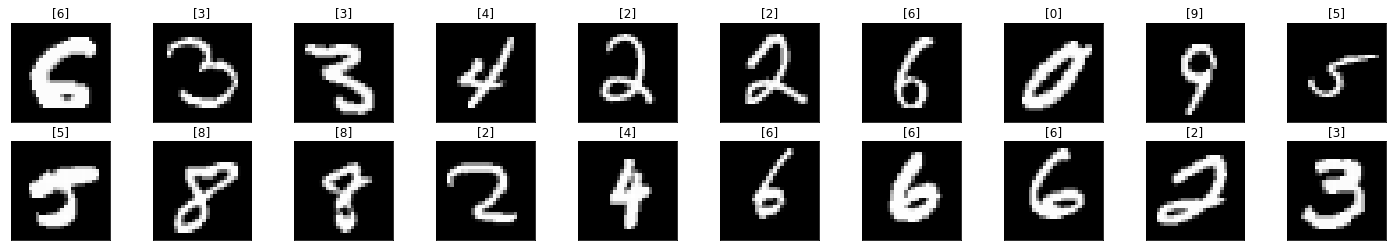

In [0]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [0]:
class Classifier(nn.Module):
  def __init__(self, d_in, H1, H2, d_out):
    super().__init__()
    self.linear1 = nn.Linear(d_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, d_out)
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [0]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [0]:
epochs = 12

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    epoch_loss = running_loss/len(training_loader)
    epoch_accuracy = running_corrects.float()/len(training_loader)
    
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_accuracy)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_accuracy = val_running_corrects.float()/len(validation_loader)
    
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_accuracy)
    print('epoch:', e)
    print('Training Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy.item(), val_epoch_loss, val_epoch_accuracy.item()))

epoch: 0
Training Loss: 0.9710, Training Accuracy: 76.5483, Validation Loss: 0.4341, Validation Accuracy: 88.3900
epoch: 1
Training Loss: 0.3748, Training Accuracy: 89.4483, Validation Loss: 0.3174, Validation Accuracy: 91.0300
epoch: 2
Training Loss: 0.3115, Training Accuracy: 90.9617, Validation Loss: 0.2781, Validation Accuracy: 91.9400
epoch: 3
Training Loss: 0.2781, Training Accuracy: 91.8900, Validation Loss: 0.2560, Validation Accuracy: 92.4200
epoch: 4
Training Loss: 0.2538, Training Accuracy: 92.5933, Validation Loss: 0.2346, Validation Accuracy: 93.1300
epoch: 5
Training Loss: 0.2336, Training Accuracy: 93.2300, Validation Loss: 0.2186, Validation Accuracy: 93.6300
epoch: 6
Training Loss: 0.2162, Training Accuracy: 93.7300, Validation Loss: 0.2064, Validation Accuracy: 93.8800
epoch: 7
Training Loss: 0.2012, Training Accuracy: 94.1950, Validation Loss: 0.1943, Validation Accuracy: 94.0800
epoch: 8
Training Loss: 0.1874, Training Accuracy: 94.5467, Validation Loss: 0.1828, Val

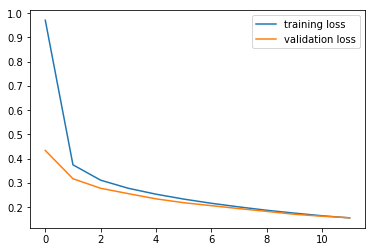

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

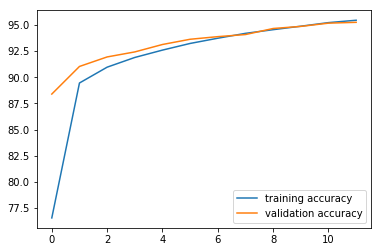

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:
# !pip3 install pillow==4.0.0

<Response [200]>


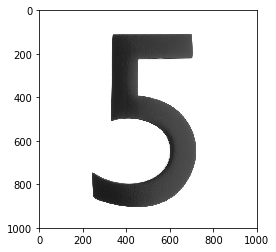

In [0]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

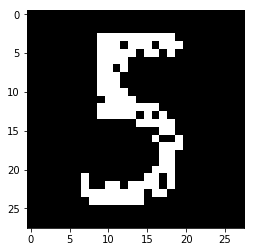

In [0]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [0]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


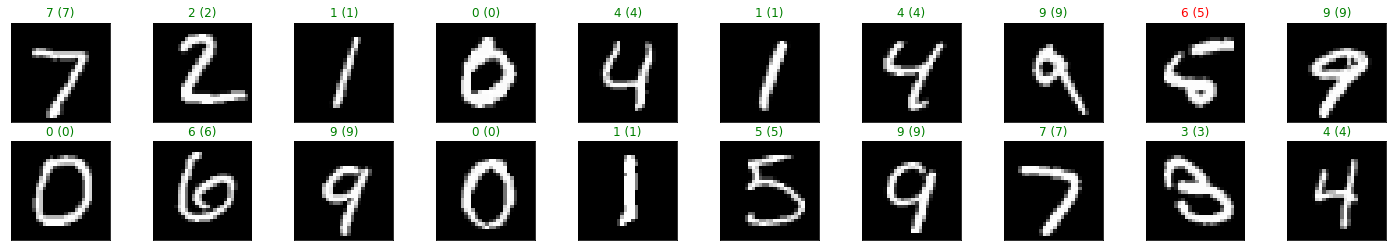

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))